In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torchsummary import summary
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Set device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# data_dir = "../data/spectrograms_split"
data_dir = "/content/drive/MyDrive/spectrograms_split"

In [5]:
# Define transformations (resize, convert to tensor, normalize using ImageNet stats)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Because the ResNet model was trained on images of this exact size. Feeding in differently-sized images would confuse it.
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])  # Make the colors of the image more uniform by subtracting the average color and dividing by how much the color varies. This helps the model learn faster and better — because the pixel values are centered and scaled. These specific numbers are the mean and standard deviation of images in the ImageNet dataset, which is what ResNet was trained on.

# The transforms.ToTensor() function is a key step in preparing image data for deep learning with PyTorch.
# It converts a PIL image (which stores pixel values as integers from 0 to 255) into a PyTorch tensor,
# which is a multi-dimensional array of floating-point numbers.
# During this process, the pixel values are scaled from the 0–255 range to a normalized range of 0.0 to 1.0.
# Additionally, the image’s dimensions are rearranged from (Height, Width, Channels),
# which is common in image libraries, to (Channels, Height, Width),
# which is the format expected by PyTorch models like ResNet.
# This transformation ensures that the image is in the correct format and value range for input into a neural network,
# making the training process more stable and efficient.

In [6]:
# find ../data/spectrograms_split -name '.DS_Store' -delete

In [7]:
# Load train, validation, test, and balanced test datasets
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
val_dataset   = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform)
test_dataset  = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform)
balanced_dataset  = datasets.ImageFolder(os.path.join(data_dir, 'test_balanced'), transform=transform)

# This code loads and prepares all your training and validation images,
# automatically assigning each one a label (a number that represents its class),
# based on the folder it's in — so your model can learn what class each image belongs to.

In [8]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)  # each time the model trains, it processes 32 images at once (a batch); uses 4 CPU threads to load the images in the background for faster training
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)
balanced_loader  = DataLoader(balanced_dataset, batch_size=32, shuffle=False, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [9]:
# Define the ResNet64 model (based on resnet50)
class ResNet64(nn.Module):
    def __init__(self, num_classes=4):  # the model is designed to classify images into 4 categories
        super(ResNet64, self).__init__()  # This line initializes the parent class (nn.Module). This is necessary in PyTorch to make sure your custom model behaves like a standard neural network.
        self.model = models.resnet50(pretrained=True)  # Load a pre-trained ResNet50 model, which has been trained on the ImageNet dataset.
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)  # Replace final layer (1000 classes in ImageNet) with a new layer that outputs the number of classes in our dataset (4 classes for spectrograms).

    def forward(self, x):
        return self.model(x)  # This method defines how the input data flows through the model. It takes an input tensor `x` and passes it through the ResNet50 model, returning the output.

In [10]:
# Instantiate model
model = ResNet64(num_classes=4).to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 192MB/s]


In [11]:
# Show model summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [12]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [13]:
# Training loop
num_epochs = 20  # model will see each training example 20 times, but likely in different shuffled orders (shuffle=True => DataLoader)
# Each epoch is broken into mini-batches (32 images per batch), and the model is updated after processing each batch.
# With each epoch, the model gradually learns better patterns from the data by adjusting its internal weights based on the loss.
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()  # clears out old gradients (otherwise they accumulate)
        loss.backward()  # computes the gradients (derivatives of the loss)
        optimizer.step()  # uses the gradients to adjust the model's weights via gradient descent

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [1/20], Loss: 0.7404
Epoch [2/20], Loss: 0.3555
Epoch [3/20], Loss: 0.2019
Epoch [4/20], Loss: 0.1370
Epoch [5/20], Loss: 0.1069
Epoch [6/20], Loss: 0.0752
Epoch [7/20], Loss: 0.0810
Epoch [8/20], Loss: 0.0653
Epoch [9/20], Loss: 0.0594
Epoch [10/20], Loss: 0.0508
Epoch [11/20], Loss: 0.0506
Epoch [12/20], Loss: 0.0417
Epoch [13/20], Loss: 0.0441
Epoch [14/20], Loss: 0.0397
Epoch [15/20], Loss: 0.0508
Epoch [16/20], Loss: 0.0270
Epoch [17/20], Loss: 0.0489
Epoch [18/20], Loss: 0.0275
Epoch [19/20], Loss: 0.0349
Epoch [20/20], Loss: 0.0256


In [14]:
# Evaluation on validation set
model.eval()  # switch model to evaluation mode (disables dropout, BatchNorm updates)

# Lists to accumulate all predictions and true labels (validation)
all_preds_val  = []
all_labels_val = []

# Variables to track correct predictions and total samples for accuracy (validation)
correct_val, total_val = 0, 0

# Disable gradient computation for faster inference and reduced memory usage
with torch.no_grad():
    for images, labels in val_loader:
        # Move images and labels to the configured device (CPU/GPU)
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)              # forward pass
        _, predicted = torch.max(outputs, 1) # predicted class is the index of the max logit

        # Update overall accuracy counts
        total_val   += labels.size(0)
        correct_val += (predicted == labels).sum().item()

        # Store predictions and labels (on CPU) for computing other metrics later
        all_preds_val.append(predicted.cpu())
        all_labels_val.append(labels.cpu())

# Compute overall accuracy as percentage (validation)
accuracy_val = 100 * correct_val / total_val
print(f"Validation Accuracy: {accuracy_val:.2f}%")

# Concatenate all batches into single arrays for metric computations
all_preds_val  = torch.cat(all_preds_val).numpy()
all_labels_val = torch.cat(all_labels_val).numpy()

# Compute macro-averaged precision, recall, and F1-score across all classes (validation)
precision_val = precision_score(all_labels_val, all_preds_val, average='macro', zero_division=0)
recall_val    = recall_score(all_labels_val, all_preds_val, average='macro', zero_division=0)
f1_val        = f1_score(all_labels_val, all_preds_val, average='macro', zero_division=0)

# Print aggregated metrics (validation)
print(f"Validation Precision (macro): {precision_val:.4f}")
print(f"Validation Recall    (macro): {recall_val:.4f}")
print(f"Validation F1‑Score   (macro): {f1_val:.4f}\n")

# Print a detailed per-class breakdown (validation)
print("Validation: Per‑class Precision / Recall / F1:\n")
print(classification_report(
    all_labels_val,
    all_preds_val,
    target_names=train_dataset.classes,  # class names inferred from dataset folders
    zero_division=0
))

# Compute and print the confusion matrix (validation)
cm_val = confusion_matrix(all_labels_val, all_preds_val)
print("Validation Confusion Matrix (rows=true, cols=predicted):\n", cm_val)

# In our four‐class sleep‐apnea classification task,
# using macro‑averaged precision, recall, and F₁‑score ensures
# that each severity category—normal, mild, moderate, and severe—is weighted equally when reporting performance.
# Because the number of spectrograms per class can vary (e.g., fewer “normal” examples than “mild” or “severe”),
# a simple overall accuracy or a weighted average could mask poor performance on the smaller classes.
# Macro‑averaging computes each metric independently for every class and then takes an unweighted mean,
# so that success on the minority class contributes as much to the final score as success on the majority classes.
# This approach aligns with our goal of diagnosing all severity levels reliably,
# rather than privileging the most common ones.

Validation Accuracy: 88.20%
Validation Precision (macro): 0.8880
Validation Recall    (macro): 0.8782
Validation F1‑Score   (macro): 0.8822

Validation: Per‑class Precision / Recall / F1:

              precision    recall  f1-score   support

        mild       0.89      0.89      0.89      1260
    moderate       0.82      0.90      0.86       740
      normal       0.92      0.86      0.89       123
      severe       0.91      0.86      0.89       978

    accuracy                           0.88      3101
   macro avg       0.89      0.88      0.88      3101
weighted avg       0.88      0.88      0.88      3101

Validation Confusion Matrix (rows=true, cols=predicted):
 [[1121   78    6   55]
 [  48  667    3   22]
 [   9    6  106    2]
 [  79   58    0  841]]


In [15]:
# Evaluation on test set
model.eval()  # switch model to evaluation mode

# Lists to accumulate all predictions and true labels (test)
all_preds_test  = []
all_labels_test = []

# Variables to track correct predictions and total samples for accuracy (test)
correct_test, total_test = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        # Move images and labels to the configured device
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Update overall accuracy counts (test)
        total_test   += labels.size(0)
        correct_test += (predicted == labels).sum().item()

        # Store predictions and labels for computing other metrics later (test)
        all_preds_test.append(predicted.cpu())
        all_labels_test.append(labels.cpu())

# Compute overall accuracy as percentage (test)
accuracy_test = 100 * correct_test / total_test
print(f"\nTest Accuracy: {accuracy_test:.2f}%")

# Concatenate all batches into single arrays for metric computations (test)
all_preds_test  = torch.cat(all_preds_test).numpy()
all_labels_test = torch.cat(all_labels_test).numpy()

# Compute macro-averaged precision, recall, and F1-score across all classes (test)
precision_test = precision_score(all_labels_test, all_preds_test, average='macro', zero_division=0)
recall_test    = recall_score(all_labels_test, all_preds_test, average='macro', zero_division=0)
f1_test        = f1_score(all_labels_test, all_preds_test, average='macro', zero_division=0)

# Print aggregated metrics (test)
print(f"Test Precision (macro): {precision_test:.4f}")
print(f"Test Recall    (macro): {recall_test:.4f}")
print(f"Test F1‑Score   (macro): {f1_test:.4f}\n")

# Print a detailed per-class breakdown (test)
print("Test: Per‑class Precision / Recall / F1:\n")
print(classification_report(
    all_labels_test,
    all_preds_test,
    target_names=test_dataset.classes,  # class names inferred from test dataset
    zero_division=0
))

# Compute and print the confusion matrix (test)
cm_test = confusion_matrix(all_labels_test, all_preds_test)
print("Test Confusion Matrix (rows=true, cols=predicted):\n", cm_test)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Test Accuracy: 87.96%
Test Precision (macro): 0.8874
Test Recall    (macro): 0.8604
Test F1‑Score   (macro): 0.8718

Test: Per‑class Precision / Recall / F1:

              precision    recall  f1-score   support

        mild       0.88      0.89      0.89      1262
    moderate       0.81      0.89      0.85       741
      normal       0.92      0.79      0.85       124
      severe       0.93      0.87      0.90       979

    accuracy                           0.88      3106
   macro avg       0.89      0.86      0.87      3106
weighted avg       0.88      0.88      0.88      3106

Test Confusion Matrix (rows=true, cols=predicted):
 [[1120   97    2   43]
 [  58  662    5   16]
 [  14    9   98    3]
 [  77   49    1  852]]


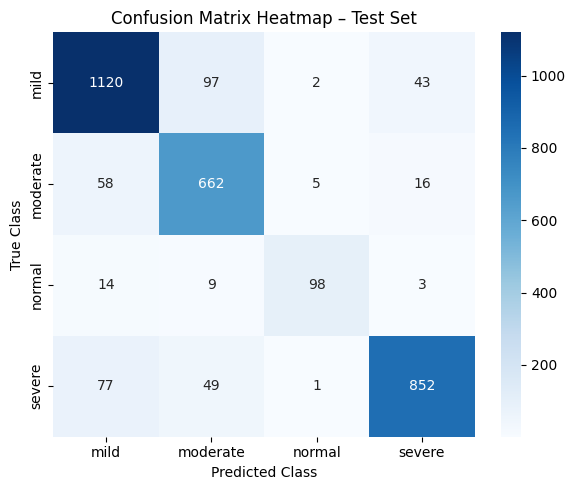

In [26]:
class_names = test_dataset.classes

plt.figure(figsize=(6, 5))
sns.heatmap(cm_test,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix Heatmap – Test Set")
plt.tight_layout()
plt.show()

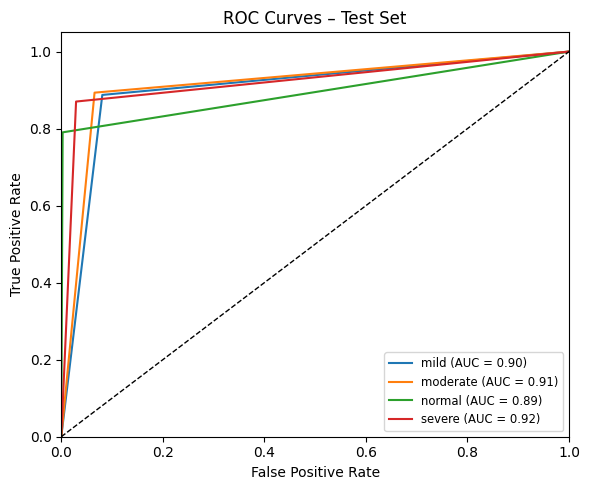

In [27]:
all_labels_onehot = label_binarize(all_labels_test, classes=np.arange(len(class_names)))
all_preds_onehot  = label_binarize(all_preds_test,  classes=np.arange(len(class_names)))

plt.figure(figsize=(6, 5))
for i, cls_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(all_labels_onehot[:, i], all_preds_onehot[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, linewidth=1.5, label=f"{cls_name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – Test Set")
plt.legend(loc="lower right", fontsize="small")
plt.tight_layout()
plt.show()

In [16]:
# Evaluation on balanced test set
model.eval()

all_preds_bal  = []
all_labels_bal = []
correct_bal, total_bal = 0, 0

with torch.no_grad():
    for images, labels in balanced_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, dim=1)

        total_bal   += labels.size(0)
        correct_bal += (predicted == labels).sum().item()

        all_preds_bal.append(predicted.cpu())
        all_labels_bal.append(labels.cpu())

accuracy_bal = 100 * correct_bal / total_bal
print(f"\nBalanced‐Test Accuracy: {accuracy_bal:.2f}%")

all_preds_bal  = torch.cat(all_preds_bal).numpy()
all_labels_bal = torch.cat(all_labels_bal).numpy()

precision_bal = precision_score(all_labels_bal, all_preds_bal, average='macro', zero_division=0)
recall_bal    = recall_score(all_labels_bal, all_preds_bal, average='macro', zero_division=0)
f1_bal        = f1_score(all_labels_bal, all_preds_bal, average='macro', zero_division=0)

print(f"Balanced Test Precision (macro): {precision_bal:.4f}")
print(f"Balanced Test Recall    (macro): {recall_bal:.4f}")
print(f"Balanced Test F1-Score   (macro): {f1_bal:.4f}\n")

print("Balanced Test: Per-class Precision / Recall / F1:\n")
print(classification_report(
    all_labels_bal,
    all_preds_bal,
    target_names=balanced_dataset.classes,
    zero_division=0
))

cm_bal = confusion_matrix(all_labels_bal, all_preds_bal)
print("Balanced Test Confusion Matrix (rows=true, cols=predicted):\n", cm_bal)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Balanced‐Test Accuracy: 84.25%
Balanced Test Precision (macro): 0.8588
Balanced Test Recall    (macro): 0.8425
Balanced Test F1-Score   (macro): 0.8443

Balanced Test: Per-class Precision / Recall / F1:

              precision    recall  f1-score   support

        mild       0.73      0.90      0.81       100
    moderate       0.81      0.88      0.84       100
      normal       0.97      0.77      0.86       100
      severe       0.92      0.82      0.87       100

    accuracy                           0.84       400
   macro avg       0.86      0.84      0.84       400
weighted avg       0.86      0.84      0.84       400

Balanced Test Confusion Matrix (rows=true, cols=predicted):
 [[90  7  1  2]
 [10 88  0  2]
 [13  7 77  3]
 [10  7  1 82]]


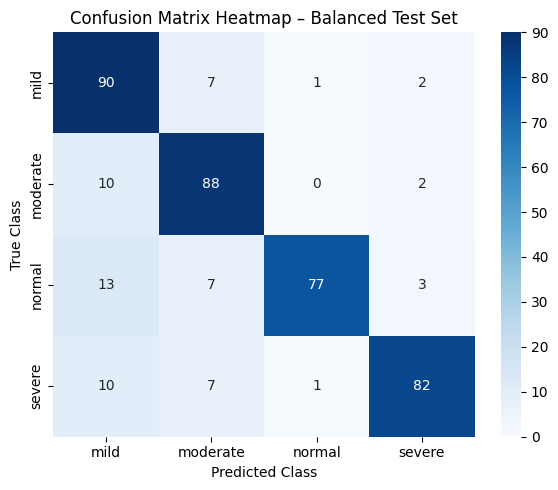

In [28]:
class_names = balanced_dataset.classes

plt.figure(figsize=(6, 5))
sns.heatmap(cm_bal,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix Heatmap – Balanced Test Set")
plt.tight_layout()
plt.show()

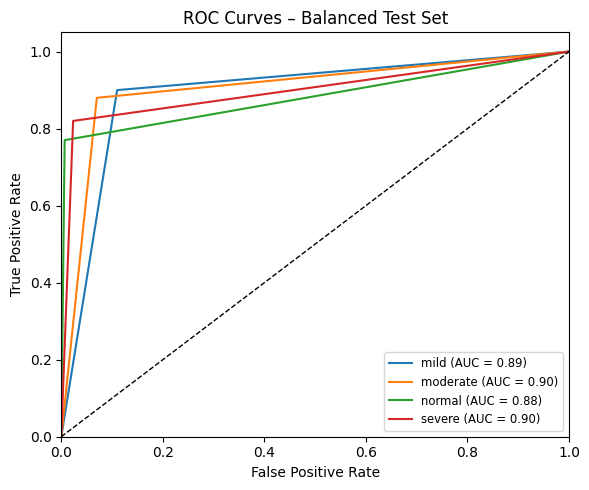

In [29]:
all_labels_onehot = label_binarize(all_labels_bal, classes=np.arange(len(class_names)))
all_preds_onehot  = label_binarize(all_preds_bal,  classes=np.arange(len(class_names)))

plt.figure(figsize=(6, 5))
for i, cls_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(all_labels_onehot[:, i], all_preds_onehot[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, linewidth=1.5, label=f"{cls_name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – Balanced Test Set")
plt.legend(loc="lower right", fontsize="small")
plt.tight_layout()
plt.show()